<a href="https://colab.research.google.com/github/VivekKejriwal/TheSchoolOfAI/blob/main/Assignment_5/Step3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#REQUIRED TRANSFORMS CREATED

train_transforms = transforms.Compose([
    transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

In [3]:
#LOADING REQUIRED MNIST DATA

train = datasets.MNIST('./data',download=True,train=True,transform= train_transforms)
test  = datasets.MNIST('./data',download=True,train=False,transform= test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

#CUDA?
cuda = torch.cuda.is_available()
#print(cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size = 128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train loader

train_loader = torch.utils.data.DataLoader(train,**dataloader_args)

#test loader

test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

NameError: ignored

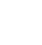

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
figure = plt.figure()
num_of_images = 60
for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r') 

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,8,3,padding=1), #INPUT- 28X28X1 OUTPUT- 28X28X8 RF- 3
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=1), #INPUT- 28X28X8 OUTPUT- 28X28X8 RF- 5
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.MaxPool2d(2,2) #RF- 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8,8,3,padding=0), #INPUT- 14X14X8 OUTPUT- 12X12X8 RF- 10
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 12X12X8 OUTPUT- 10X10X8 RF-14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 10X10X8 OUTPUT- 8X8X8 RF- 18
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,16,3,padding=0), #INPUT- 8X8X8 OUTPUT- 6X6X16 RF- 22
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.01)
        
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16,32,3), #INPUT- 6X6X16 OUTPUT- 4X4X32 RF-24
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.01),
        
        nn.AvgPool2d(4), #INPUT- 4X4X32 OUTPUT- 1X1X32 RF-40
        
        nn.Conv2d(32,10,1) #INPUT- 1X1X32 OUTPUT- 1X1X10
        
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=1)


In [7]:
!pip install torchsummary

from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size = (1, 28, 28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 12, 12]             584
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model,device,train_loader,optimizer,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_id,(data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)

    loss= F.nll_loss(y_pred,target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed+= len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_size={batch_id} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model,device,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss = F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim= 1,keepdim=True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Acccuracy= {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)))
  
  test_acc.append(100.*correct/len(test_loader.dataset))



In [10]:



model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

EPOCHS = 20

for epoch in range(EPOCHS):
  print("EPOCH: ",epoch)
  train(model,device,train_loader,optimizer,epoch)
  test (model,device,test_loader)
  

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  0


Loss=0.06871438771486282 Batch_size=468 Accuracy=87.83: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9791/10000 (97.91%)

EPOCH:  1


Loss=0.06663520634174347 Batch_size=468 Accuracy=97.55: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9874/10000 (98.74%)

EPOCH:  2


Loss=0.07079127430915833 Batch_size=468 Accuracy=98.09: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9865/10000 (98.65%)

EPOCH:  3


Loss=0.034738436341285706 Batch_size=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9880/10000 (98.80%)

EPOCH:  4


Loss=0.04880352318286896 Batch_size=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9920/10000 (99.20%)

EPOCH:  5


Loss=0.08472230285406113 Batch_size=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9915/10000 (99.15%)

EPOCH:  6


Loss=0.1097782626748085 Batch_size=468 Accuracy=98.65: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9896/10000 (98.96%)

EPOCH:  7


Loss=0.029523983597755432 Batch_size=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9921/10000 (99.21%)

EPOCH:  8


Loss=0.054071277379989624 Batch_size=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9926/10000 (99.26%)

EPOCH:  9


Loss=0.049456819891929626 Batch_size=468 Accuracy=98.80: 100%|██████████| 469/469 [00:16<00:00, 28.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9920/10000 (99.20%)

EPOCH:  10


Loss=0.013424237258732319 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Acccuracy= 9927/10000 (99.27%)

EPOCH:  11


Loss=0.04164329543709755 Batch_size=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9924/10000 (99.24%)

EPOCH:  12


Loss=0.05588381364941597 Batch_size=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9937/10000 (99.37%)

EPOCH:  13


Loss=0.028730319812893867 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH:  14


Loss=0.010967605747282505 Batch_size=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9930/10000 (99.30%)

EPOCH:  15


Loss=0.02017664536833763 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9935/10000 (99.35%)

EPOCH:  16


Loss=0.023721719160676003 Batch_size=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9949/10000 (99.49%)

EPOCH:  17


Loss=0.04812438413500786 Batch_size=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9927/10000 (99.27%)

EPOCH:  18


Loss=0.010213104076683521 Batch_size=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9940/10000 (99.40%)

EPOCH:  19


Loss=0.022170662879943848 Batch_size=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]



Test set: Average loss: 0.0000, Acccuracy= 9939/10000 (99.39%)



In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:

        Add Batch-norm,dropout regularization and image augmentation
        to increase model efficiency.

Results:

        Parameters: 8,730
        Best Train Accuracy: 99.09
        Best Test Accuracy: 99.49(17th Epoch)

Analysis:

        VERY good model but let's see if we can achieve more without waiting 
        for that much of epochs

